In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
df = pd.read_csv(r"D:\dataset\nsq.csv")

In [2]:
df.head()

,Date,Volume
0,1/2/1990,110720000.0
1,1/3/1990,152660000.0
2,1/4/1990,147950000.0
3,1/5/1990,137230000.0
4,1/8/1990,115500000.0


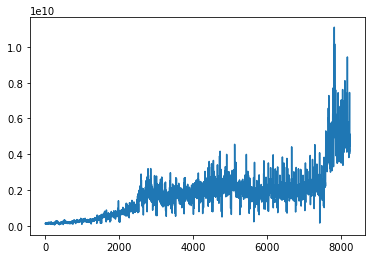

In [3]:
import matplotlib.pyplot as plt
plt.plot(df['Volume'])

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
df=df.dropna(axis=0,how='any')
df1=df['Volume']
scalar = MinMaxScaler(feature_range=(0,1))
df1 = scalar.fit_transform(np.array(df1).reshape(-1,1))

In [22]:
df1

array([[0.00601468],
       [0.00980742],
       [0.00938149],
       ...,
       [0.46031498],
       [0.42083026],
       [0.39797973]])

In [23]:
print(df1.shape)

(8249, 1)


In [24]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [25]:
class StockDataset(Dataset):
    def __init__(self,data,seq_len = 100):
        self.data = data
        self.data = torch.from_numpy(data).float().view(-1)
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.data)-self.seq_len-1

    def __getitem__(self, index) :
        return  self.data[index : index+self.seq_len] , self.data[index+self.seq_len]


train_dataset = StockDataset(train_data) 
test_dataset = StockDataset(test_data) 

In [26]:
batch_size = 64
train_dataloader = DataLoader(train_dataset,batch_size,drop_last=True)
test_dataloader = DataLoader(test_dataset,batch_size , drop_last=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim , hidden_size , num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim , hidden_size = hidden_size , num_layers= num_layers )
        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x,hn,cn):
        out , (hn,cn) = self.lstm(x , (hn,cn))
        final_out = self.fc(out[-1])
        return final_out,hn,cn

    def predict(self,x):
        hn,cn  = self.init()
        final_out = self.fc(out[-1])
        return final_out

    def init(self):
        h0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        c0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        return h0 , c0


input_dim = 1 
hidden_size = 50
num_layers = 4

model = Lstm_model(input_dim , hidden_size , num_layers).to(device)

In [28]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [29]:
def train(dataloader):
    hn , cn = model.init()
    model.train()
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(100,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
        hn = hn.detach()
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch == len(dataloader)-1:
            loss = loss.item()
            print(f"train loss: {loss:>7f} ")

In [30]:
def test(dataloader):
    hn , cn = model.init()
    model.eval()
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(100,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
       
        if batch == len(dataloader)-1:
            loss = loss.item()
            print(f"test loss: {loss:>7f} ")

In [31]:
epochs = 50
for epoch in range(epochs):
    print(f"epoch {epoch} ")
    train(train_dataloader)
    test(test_dataloader)

epoch 0 
train loss: 0.001598 
test loss: 0.077265 
epoch 1 
train loss: 0.001114 
test loss: 0.084107 
epoch 2 
train loss: 0.003016 
test loss: 0.065680 
epoch 3 
train loss: 0.001412 
test loss: 0.077503 
epoch 4 
train loss: 0.002677 
test loss: 0.069402 
epoch 5 
train loss: 0.001562 
test loss: 0.071961 
epoch 6 
train loss: 0.001119 
test loss: 0.094964 
epoch 7 
train loss: 0.001653 
test loss: 0.103204 
epoch 8 
train loss: 0.001951 
test loss: 0.106644 
epoch 9 
train loss: 0.002002 
test loss: 0.107134 
epoch 10 
train loss: 0.002136 
test loss: 0.108491 
epoch 11 
train loss: 0.002260 
test loss: 0.109671 
epoch 12 
train loss: 0.002318 
test loss: 0.110180 
epoch 13 
train loss: 0.002323 
test loss: 0.110231 
epoch 14 
train loss: 0.002153 
test loss: 0.108478 
epoch 15 
train loss: 0.001982 
test loss: 0.106753 
epoch 16 
train loss: 0.002256 
test loss: 0.109450 
epoch 17 
train loss: 0.002427 
test loss: 0.111046 
epoch 18 
train loss: 0.002379 
test loss: 0.110643 
epo

In [32]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(data_loader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn , cn = model.init()
        for batch , item in enumerate(data_loader):
            x , y = item
            x , y = x.to(device) , y.to(device)
            x = x.view(100,64,1)
            pred = model(x,hn,cn)[0]
            pred = scalar.inverse_transform(pred.detach().cpu().numpy()).reshape(-1)
            y = scalar.inverse_transform(y.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
        print(pred_arr[130],y_arr[130])
        return math.sqrt(mean_squared_error(y_arr,pred_arr))

In [33]:
# calculating final loss metrics
print(f"train mse loss {calculate_metrics(train_dataloader)}")
print(f"test mse loss {calculate_metrics(test_dataloader)}")

1431039700.0 128590000.0
train mse loss 837788601.1788572
1431042700.0 1589360000.0
test mse loss 1766081774.09026


In [8]:
(1589360000.0 - 1431042700.0)/1589360000


0.09961072381335884